In [1]:
import os
import numpy as np
# import cupy as cp
# import numba as nb
import datetime as dt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import h5py
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
# from attention import Attention
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
len(tf.config.list_physical_devices('GPU'))
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
tf.test.is_gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
df = pd.read_csv('F:\Work\Time Series Forecast_Water Levels\DL for Time Series Forecast\data_43_temp.csv')
# df['Hour'] = df['Hour'].replace('#NUM!', 0)
# df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time

# df['Hour'] = df['Hour'].astype(str)

df = df[['TimeVN', '48808']]
df['DateTime'] = pd.to_datetime(df['TimeVN'])
df = df.set_index('DateTime')
df.drop(['TimeVN'], 
        axis = 1, inplace = True)
df.head()

,48808
DateTime,
2014-01-01 01:00:00,6.7
2014-01-01 04:00:00,6.0
2014-01-01 07:00:00,5.6
2014-01-01 10:00:00,7.3
2014-01-01 13:00:00,18.6


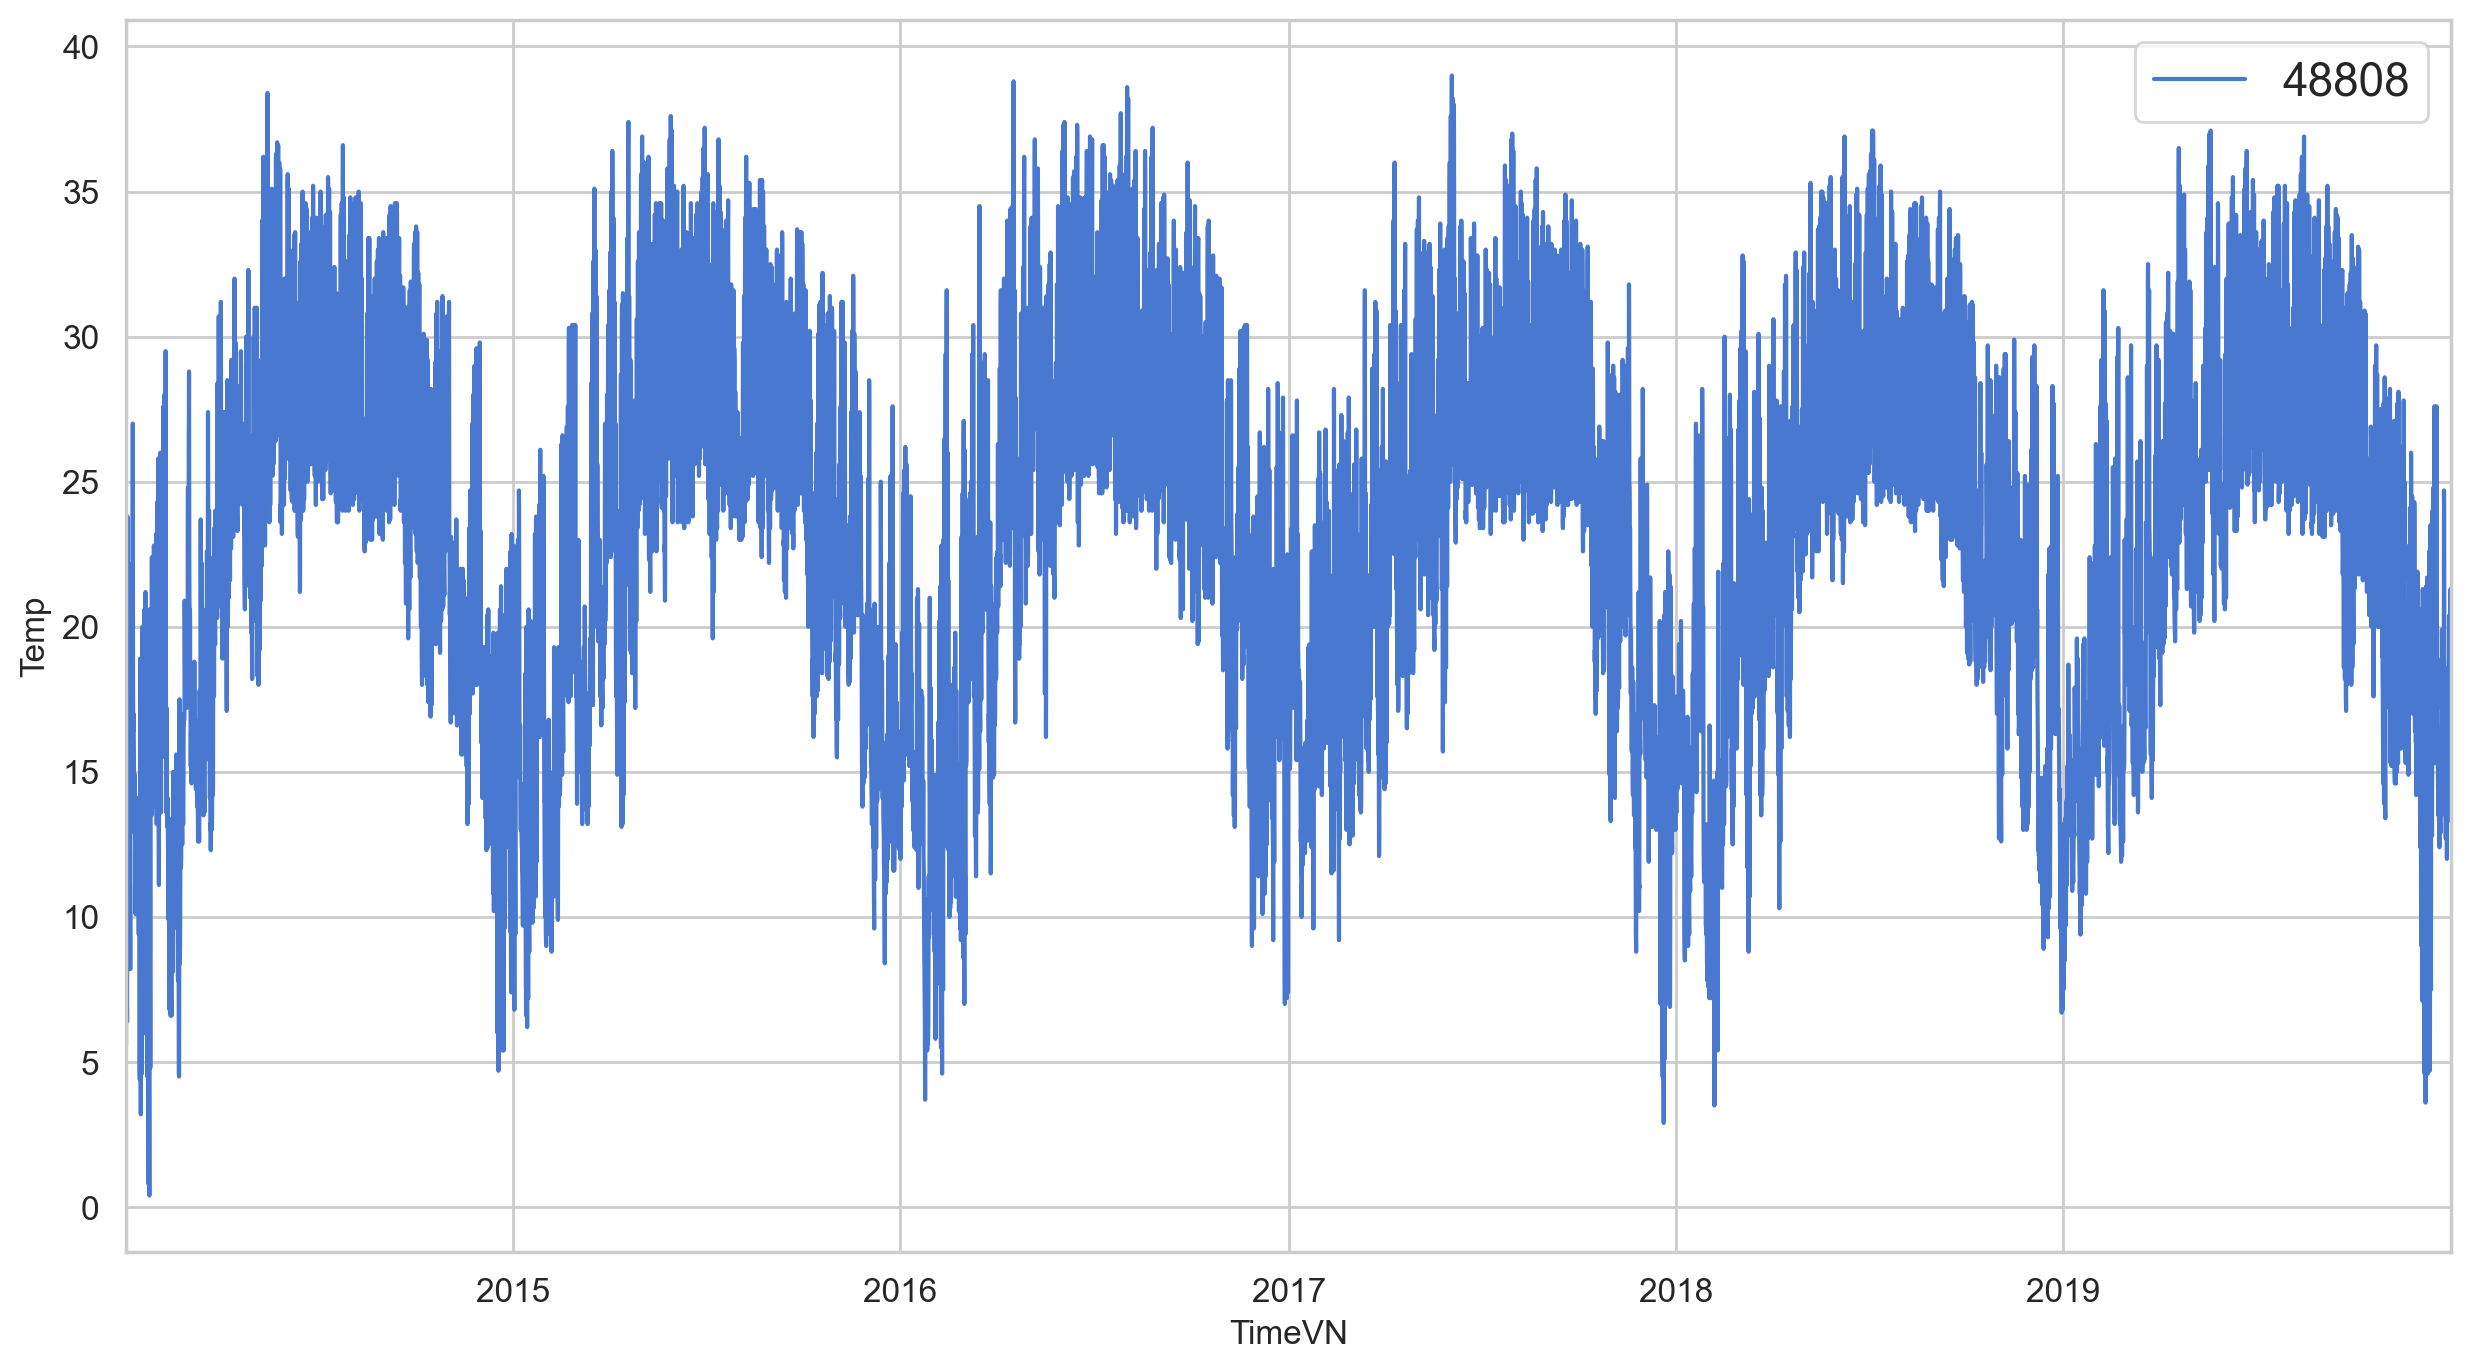

In [5]:
df.plot(y='48808', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('TimeVN', fontsize=12)
plt.ylabel('Temp', fontsize=12)
plt.show()

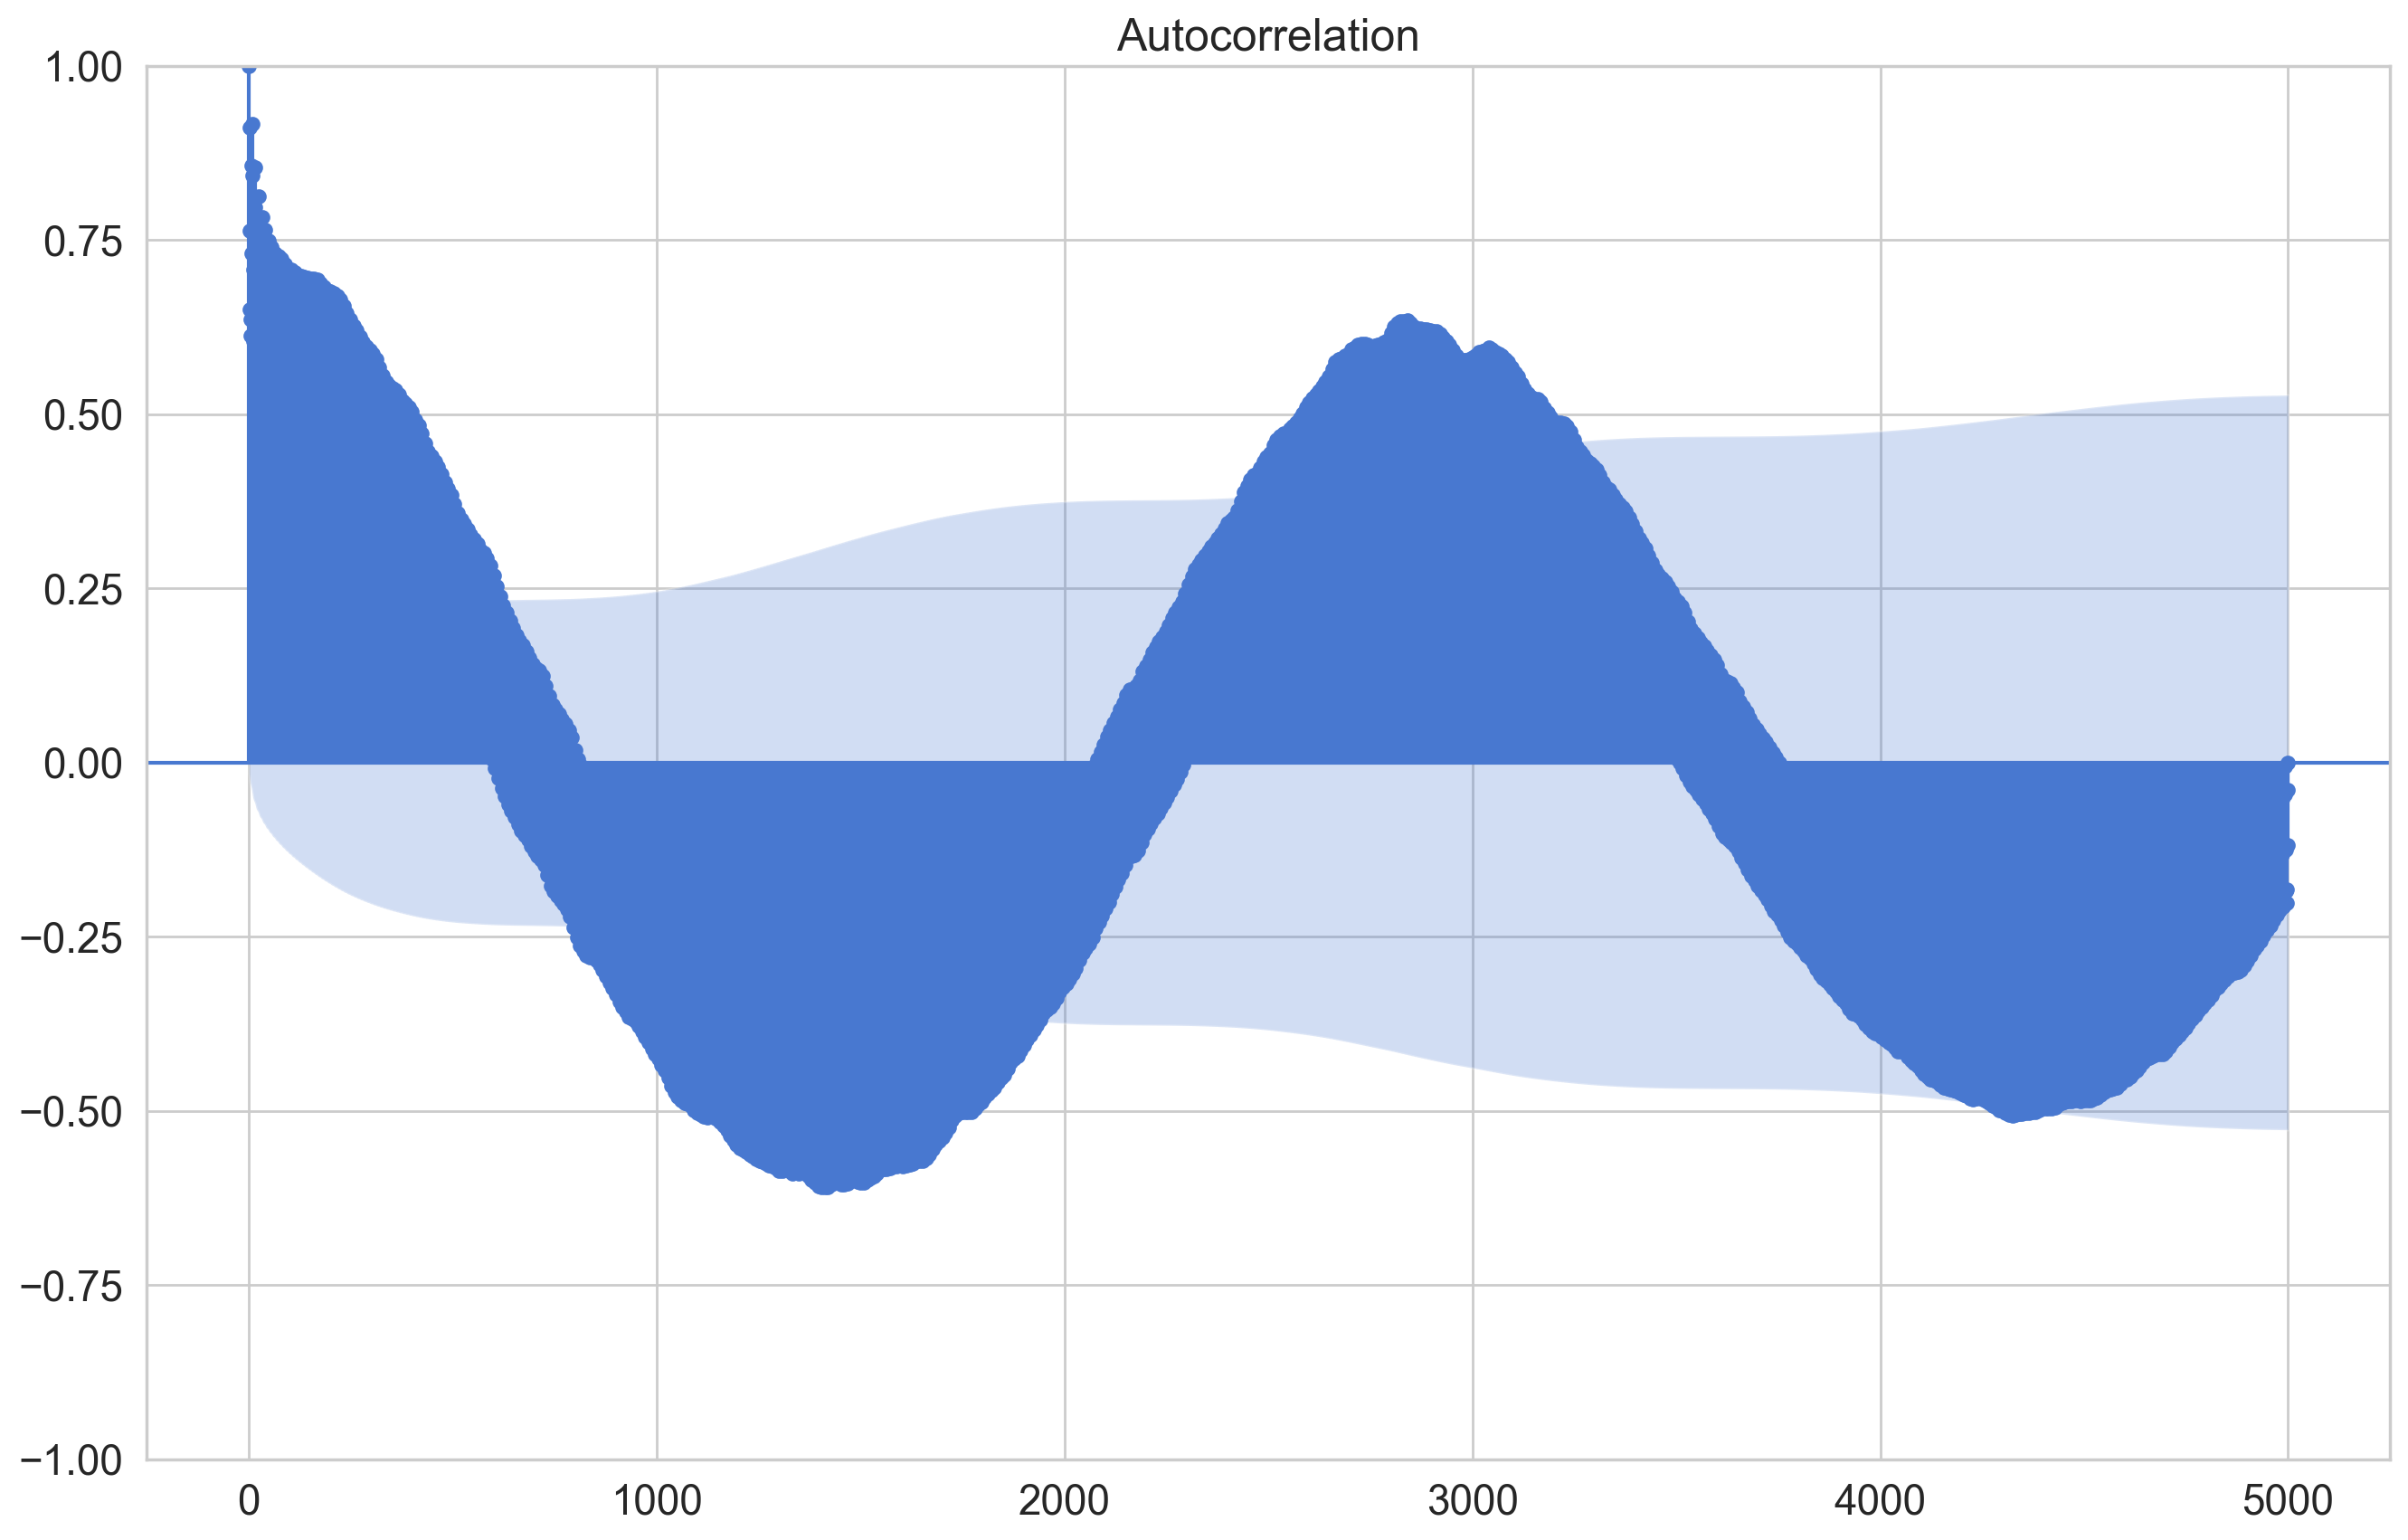

In [6]:
plot_acf(df['48808'].values, lags=5000)
plt.show()

Vị trí của các đỉnh (lag): [ 8 16 24 32 40 48 56 64 72 80 88 96]


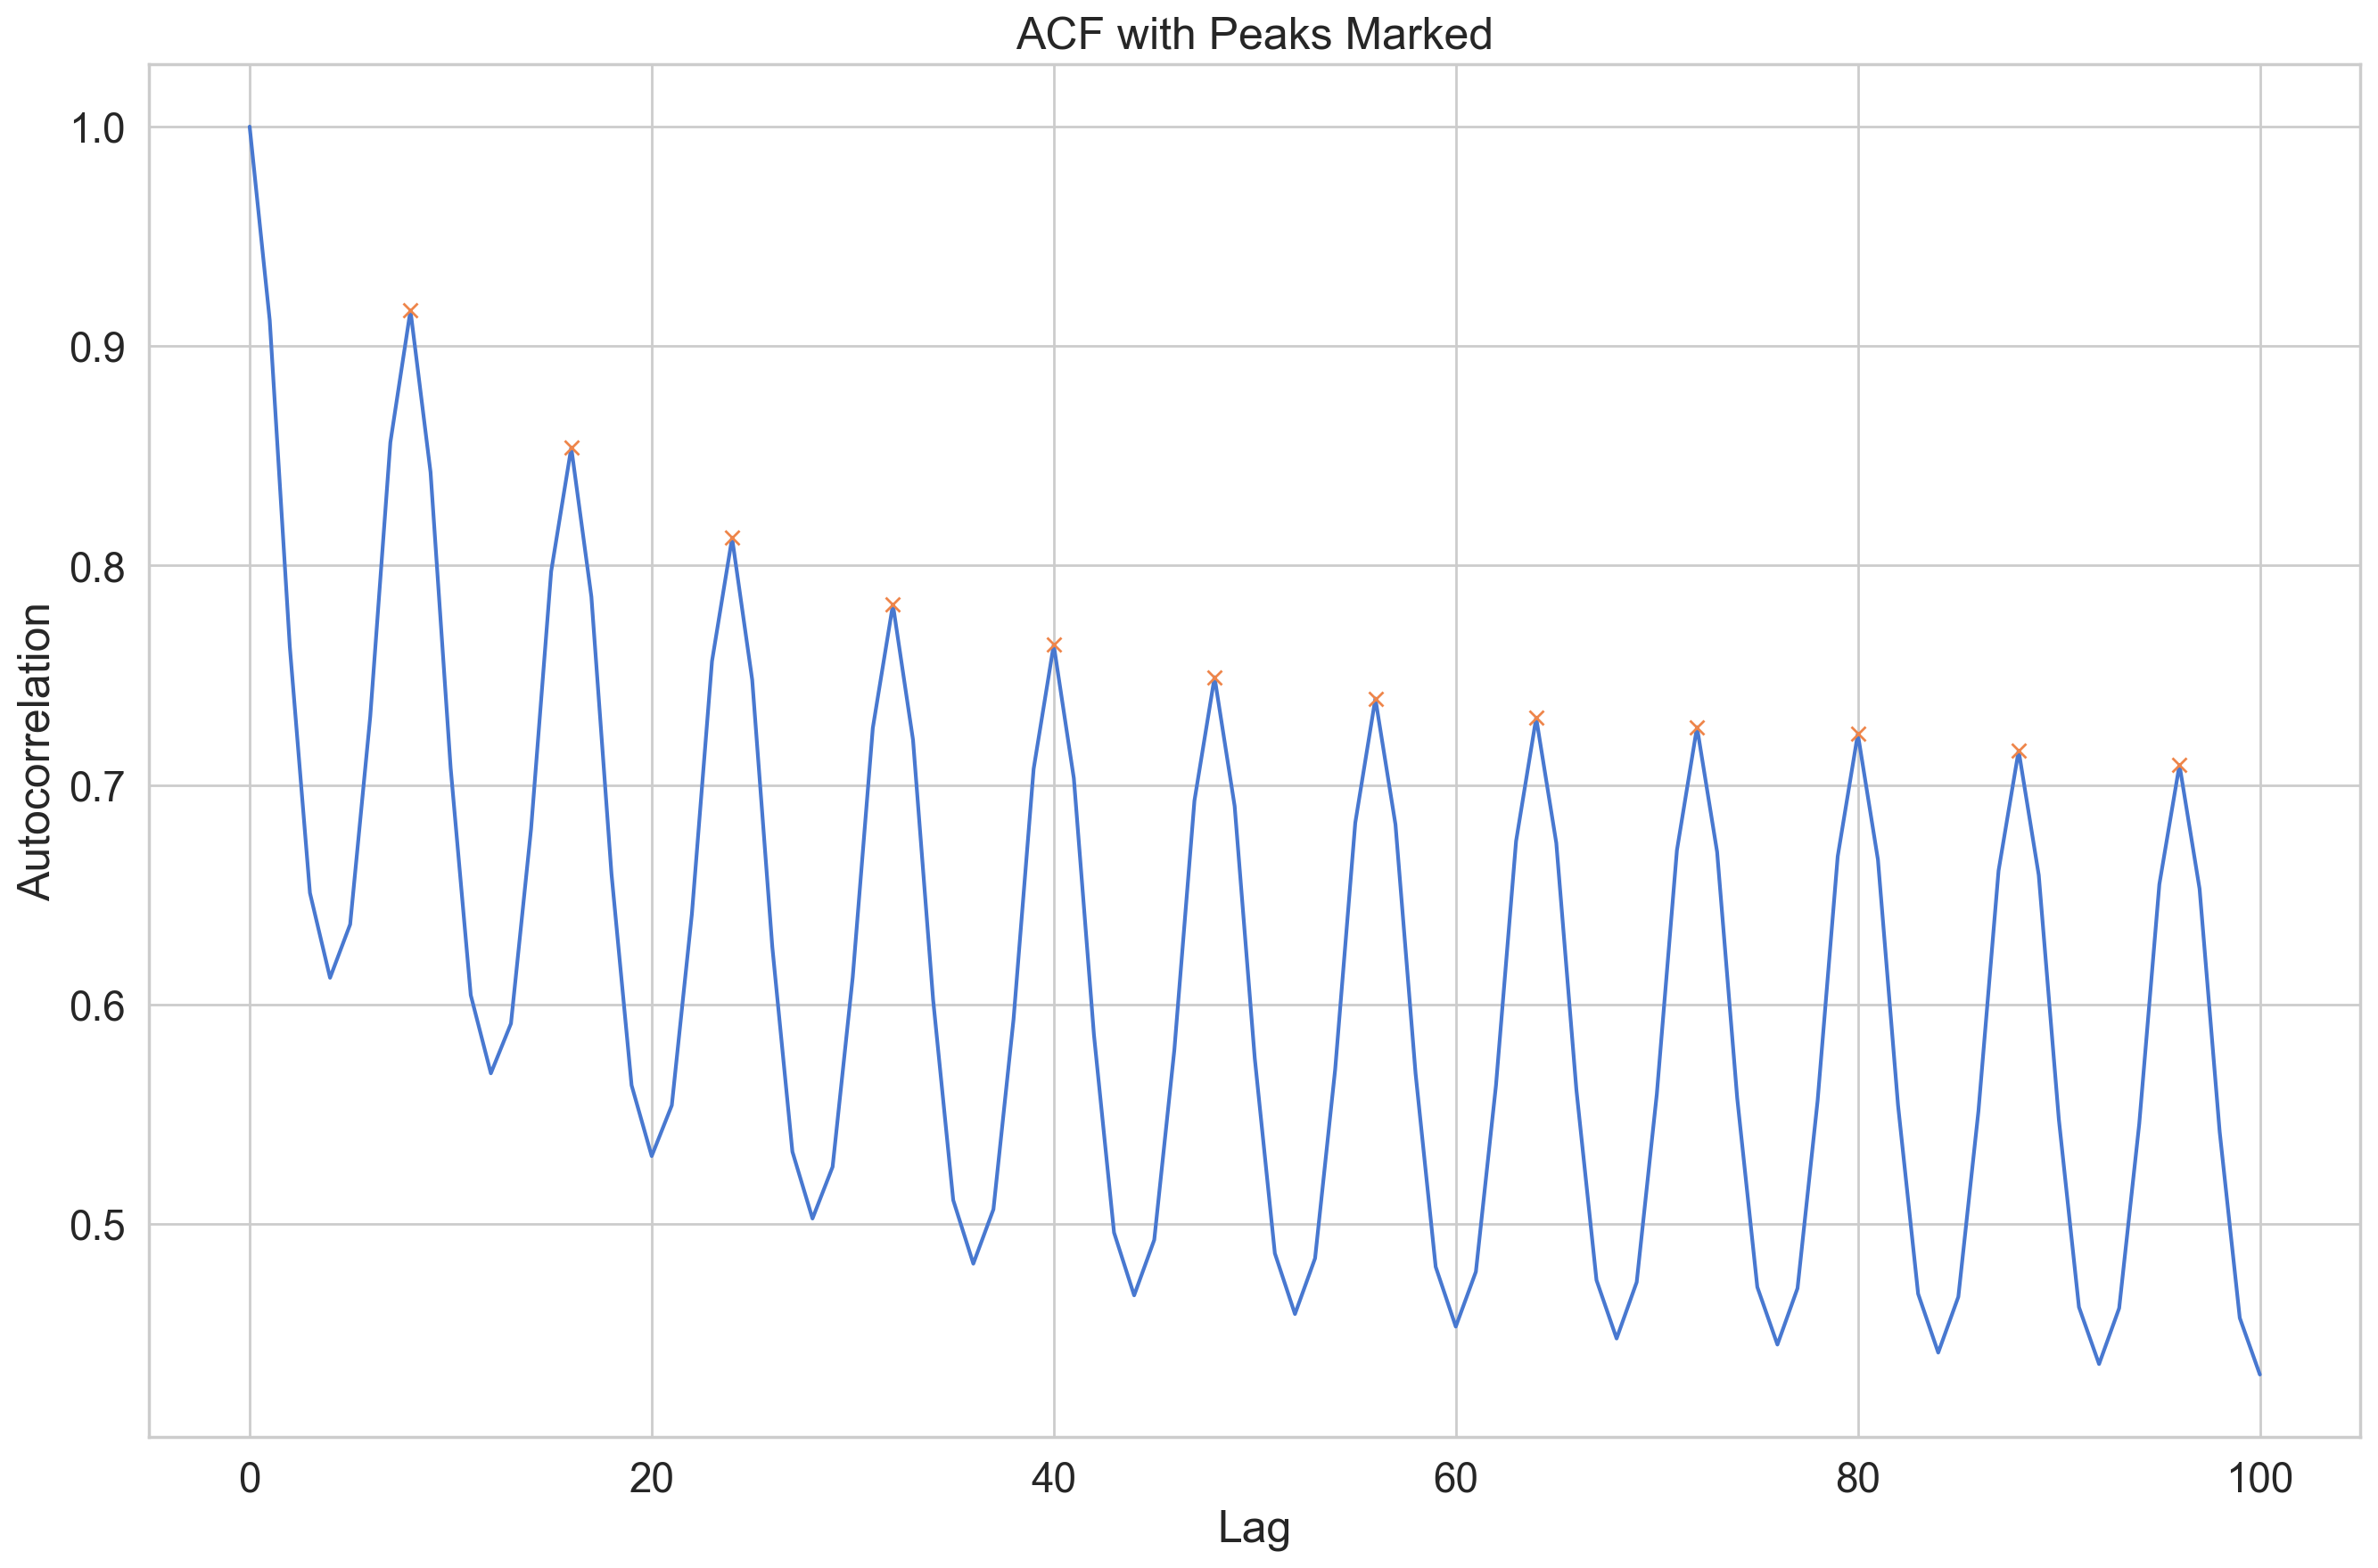

In [7]:
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
acf_values = acf(df['48808'].values, nlags=100)

# Tìm các đỉnh trong ACF
peaks, _ = find_peaks(acf_values)

# In ra vị trí của các đỉnh
print("Vị trí của các đỉnh (lag):", peaks)

# Plot ACF với các đỉnh được đánh dấu
plt.plot(acf_values)
plt.plot(peaks, acf_values[peaks], "x")
plt.title('ACF with Peaks Marked')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [8]:
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.9)
train, val, test = df[:train_size].iloc[:, [0]], df[train_size:val_size].iloc[:, [0]] , df[val_size:].iloc[:, [0]]

train, val, test

(                     48808
 DateTime                  
 2014-01-01 01:00:00    6.7
 2014-01-01 04:00:00    6.0
 2014-01-01 07:00:00    5.6
 2014-01-01 10:00:00    7.3
 2014-01-01 13:00:00   18.6
 ...                    ...
 2018-10-19 04:00:00   18.8
 2018-10-19 07:00:00   19.1
 2018-10-19 10:00:00   20.9
 2018-10-19 13:00:00   22.3
 2018-10-19 16:00:00   22.0
 
 [14022 rows x 1 columns],
                      48808
 DateTime                  
 2018-10-19 19:00:00   21.2
 2018-10-19 22:00:00   20.8
 2018-10-20 01:00:00   20.6
 2018-10-20 04:00:00   20.6
 2018-10-20 07:00:00   20.7
 ...                    ...
 2019-05-26 07:00:00   26.3
 2019-05-26 10:00:00   31.5
 2019-05-26 13:00:00   34.6
 2019-05-26 16:00:00   34.4
 2019-05-26 19:00:00   30.4
 
 [1753 rows x 1 columns],
                      48808
 DateTime                  
 2019-05-26 22:00:00   28.6
 2019-05-27 01:00:00   28.1
 2019-05-27 04:00:00   27.5
 2019-05-27 07:00:00   26.1
 2019-05-27 10:00:00   23.2
 ...               

In [9]:
train.shape, val.shape, test.shape

((14022, 1), (1753, 1), (1753, 1))

Text(0, 0.5, 'Temp')

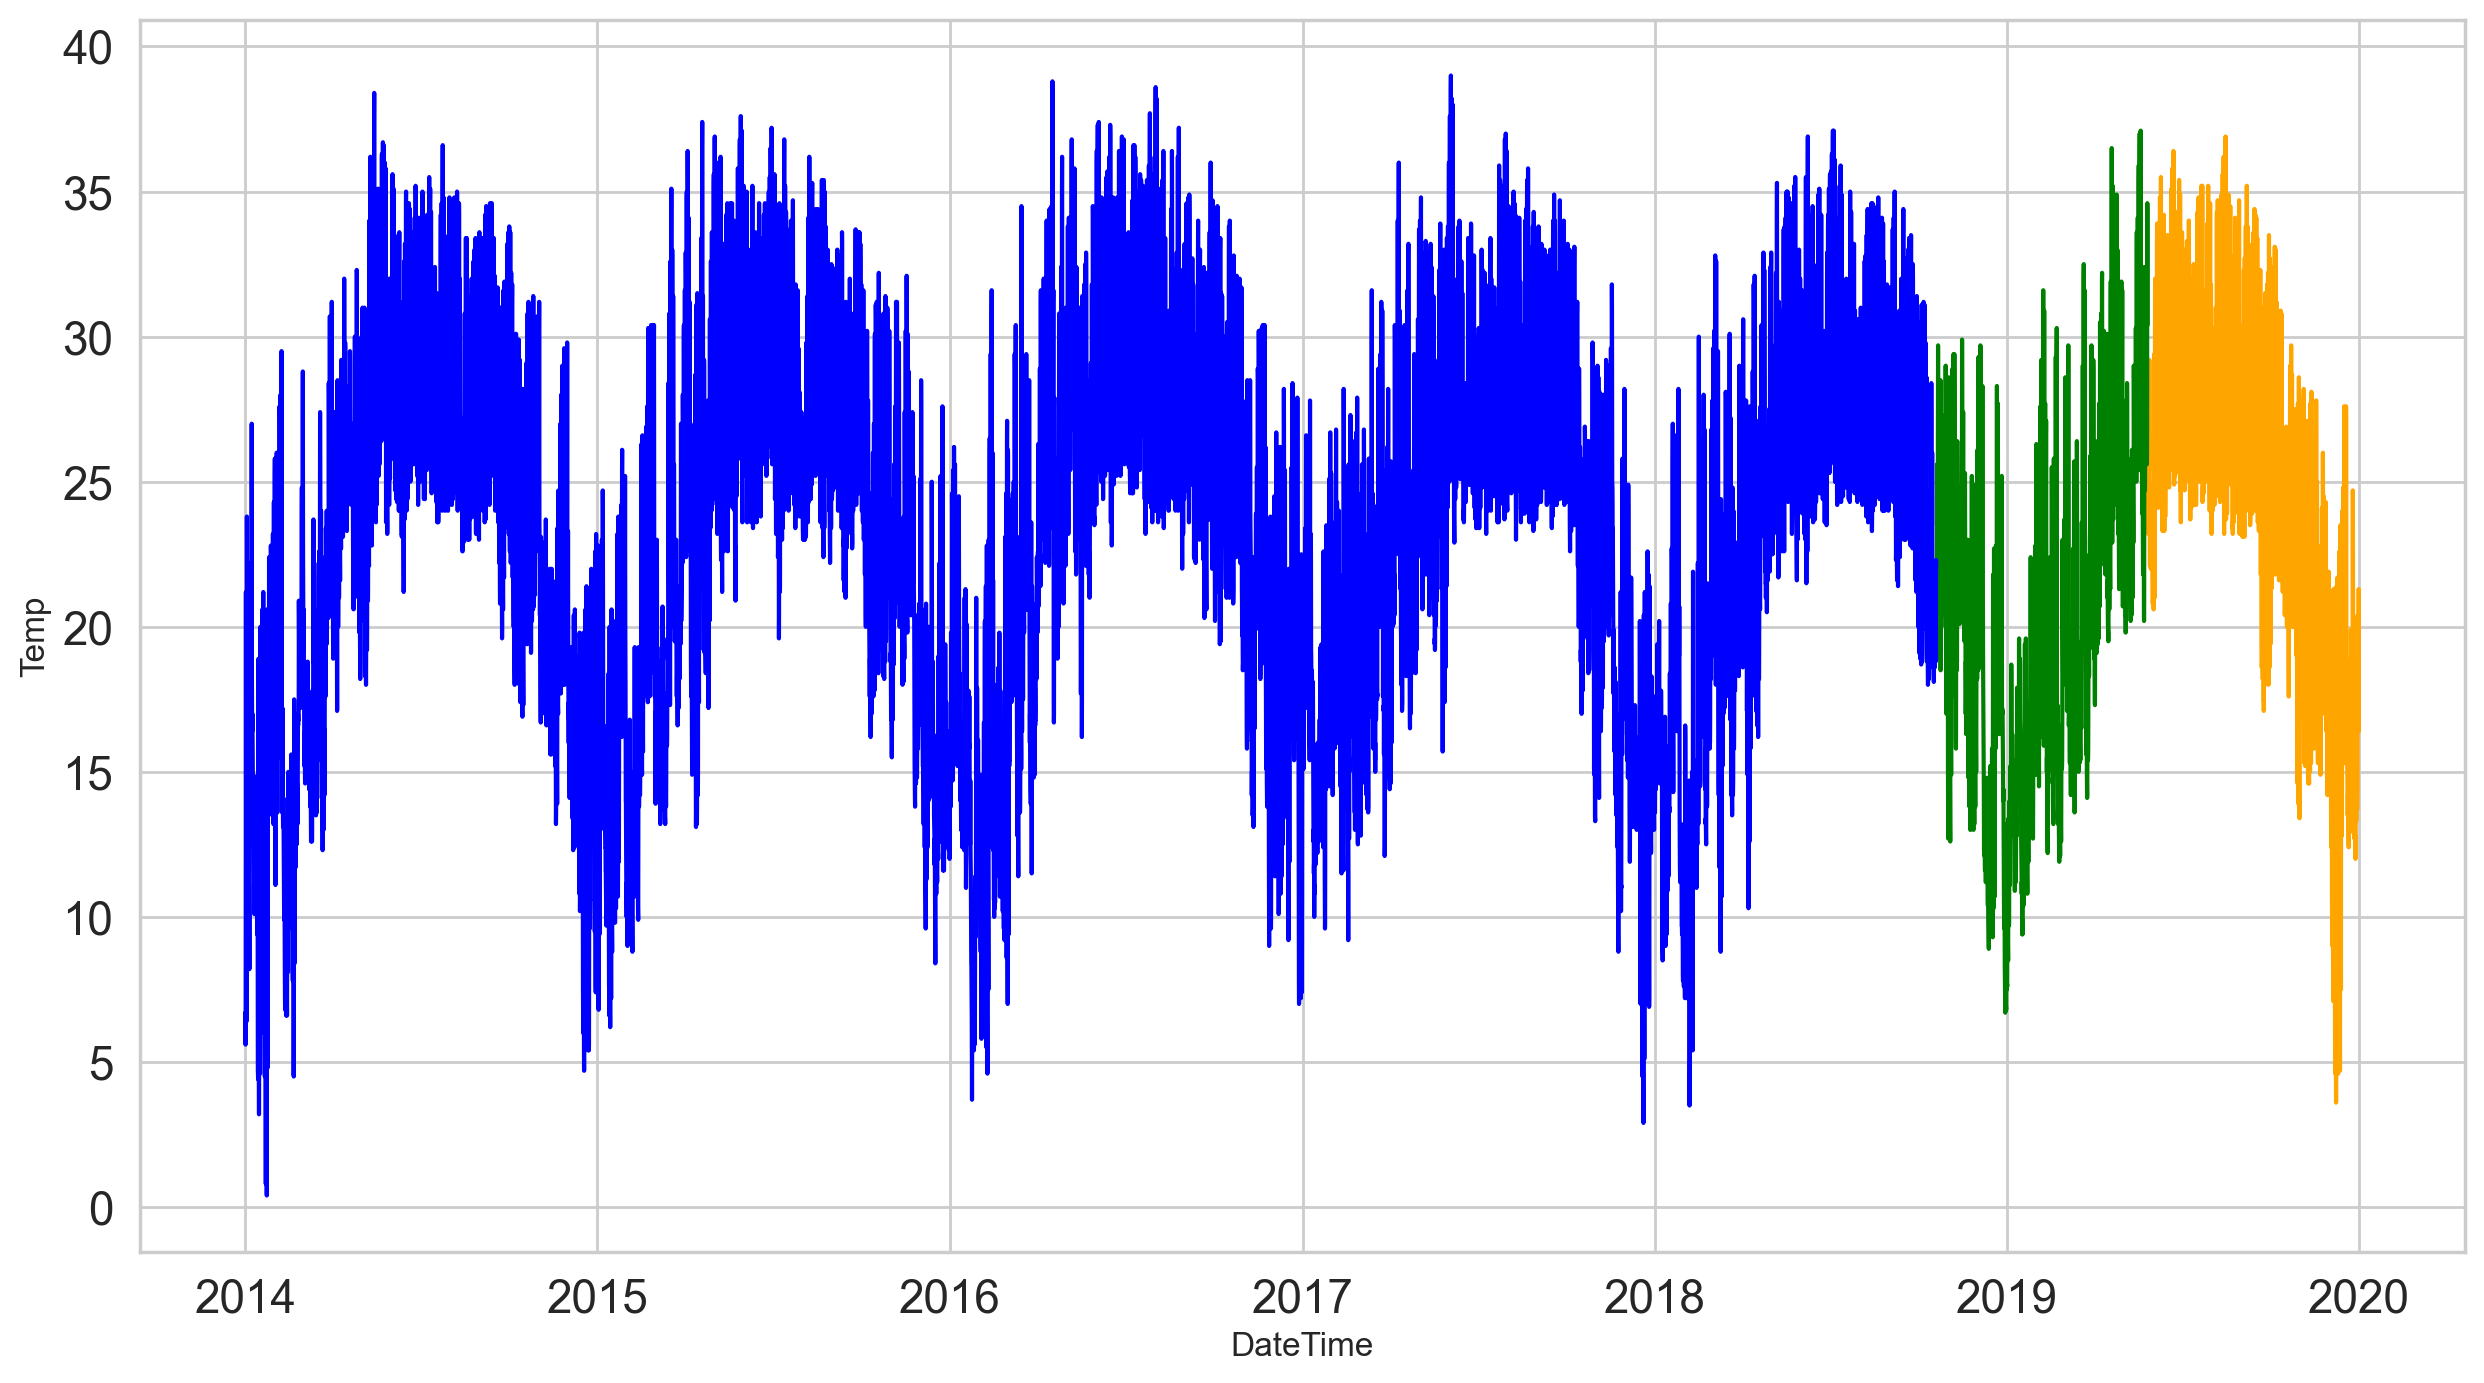

In [10]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['48808'], label = "test", color = 'orange')
plt.plot(val.index, val['48808'], label = "val", color = 'green')
plt.plot(train.index, train['48808'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Temp', fontsize=12)

In [11]:
scaler = MinMaxScaler()
train['48808'] = scaler.fit_transform(train)
val['48808'] = scaler.transform(val)
test['48808'] = scaler.transform(test)

In [12]:
train_data = train.values
val_data = val.values
test_data = test.values
timesteps = 96

In [13]:
train_data.shape

(14022, 1)

In [14]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] 
                             for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [15]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.16321244, 0.14507772, 0.13471503, ..., 0.34715026, 0.35233161,
         0.31088083],
        [0.14507772, 0.13471503, 0.17875648, ..., 0.35233161, 0.31088083,
         0.29533679],
        [0.13471503, 0.17875648, 0.47150259, ..., 0.31088083, 0.29533679,
         0.26943005],
        ...,
        [0.77202073, 0.79533679, 0.62953368, ..., 0.47927461, 0.47668394,
         0.48445596],
        [0.79533679, 0.62953368, 0.55958549, ..., 0.47668394, 0.48445596,
         0.53108808],
        [0.62953368, 0.55958549, 0.55699482, ..., 0.48445596, 0.53108808,
         0.56735751]]),
 array([[0.29533679],
        [0.26943005],
        [0.2642487 ],
        ...,
        [0.53108808],
        [0.56735751],
        [0.55958549]]))

In [16]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    squared_error = np.mean((y_true - y_pred)**2)

#     r, _ = pearsonr(y_true, y_pred)
    correlation_matrix = np.corrcoef(y_true, y_pred)
    r = correlation_matrix[0, 1]
    
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'SIM': sim,
        'MAE': mae,
        'RMSE': rmse,
        'FSD': fsd,
        'R': r,
        'NSE': nse,
        'MSE' : squared_error
        
    }



In [17]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), 
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), 
                                 initializer='zeros', trainable=True)        
        super(AttentionLayer, self).build(input_shape)
 
    def call(self, x):
        e = tf.tanh(tf.linalg.matmul(x, self.W) + self.b)
        e = tf.squeeze(e, axis=-1)
        alpha = tf.nn.softmax(e)
        alpha = tf.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = tf.reduce_sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [18]:
# time = int(input("Enter the first time you want to forecast:"))
time = 0
hours = 120
pred = []

def forecast(model, hours, time):
    pred = []
    # current_window = x_val[-1,:].tolist()
    current_window = x_test[time,:].tolist()
    for i in range(hours):
        # Chuyển current_window thành numpy array khi gọi predict
        y_pred = model.predict(np.asarray([current_window]), verbose=0)[0]
        pred.append(float(y_pred[0]))
        current_window.pop(0)
        current_window.append(pred[-1])
    pred_array = np.array(pred).reshape(-1, 1)
    return pred_array

# Model


In [19]:
def CNN_model():
    model = keras.Sequential()

    model.add(Conv1D(8, 3, activation='relu', padding = 'same',
                                input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(16, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(32, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    
    model.add(Flatten())

    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense((1), 'linear'))

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.0001),
        metrics=[RootMeanSquaredError()]
        )
    return model

In [20]:
def LSTM_model():
    model = keras.Sequential()

    model.add(keras.layers.LSTM(units=512, activation = 'tanh',
                                return_sequences=True, 
                                input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(keras.layers.LSTM(units=256,activation = 'tanh',
                                return_sequences=True))
    model.add(Dropout(0.1))
    model.add(keras.layers.LSTM(units=64,activation = 'tanh',
                                return_sequences=True))
    model.add(Dropout(0.1))
    model.add(keras.layers.LSTM(units=32,activation = 'tanh'))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense((1), 'linear'))

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.0001),
        metrics=[RootMeanSquaredError()]
    )
    return model

In [21]:
def CNN_LSTM_model():
    model = keras.Sequential()

    model.add(Conv1D(8, 3, activation='relu', padding = 'same',
                                input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(16, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(32, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(keras.layers.LSTM(units=256,activation = 'tanh'))
    model.add(Dropout(0.1))
    model.add(Flatten())

    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense((1), 'linear'))

    model.compile(
      loss=MeanSquaredError(),
      optimizer=Adam(learning_rate=0.0001),
      metrics=[RootMeanSquaredError()]
    )
    return model

In [22]:
def CNN_A_model():
    model = keras.Sequential()

    model.add(Conv1D(8, 3, activation='relu', padding = 'same',
                                input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(16, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(32, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(AttentionLayer())
    model.add(Flatten())
    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense((1), 'linear'))

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.0001),
        metrics=[RootMeanSquaredError()]
    )
    return model


In [23]:
def LSTM_A_model():
    model = keras.Sequential()

    model.add(keras.layers.LSTM(units=512, activation = 'tanh',
                                return_sequences=True, 
                                input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(keras.layers.LSTM(units=256,activation = 'tanh',
                                return_sequences=True))
    model.add(Dropout(0.1))
    model.add(keras.layers.LSTM(units=64,activation = 'tanh',
                                return_sequences=True))
    model.add(Dropout(0.1))
    # model.add(keras.layers.LSTM(units=32,activation = 'tanh',
    #                             return_sequences=True))
    # model.add(Dropout(0.1))

    model.add(AttentionLayer())
    model.add(Flatten())
    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense((1), 'linear'))

    model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError()]
    )
    return model

In [24]:
def CNN_LSTM_A_model():
    model = keras.Sequential()

    model.add(Conv1D(8, 3, activation='relu', padding = 'same',
                                input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(16, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(32, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(64, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(keras.layers.LSTM(units=256,activation = 'tanh', return_sequences=True))
    model.add(Dropout(0.1))

    model.add(AttentionLayer())
    model.add(Flatten())
    model.add(Dense(128, 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense((1), 'linear'))

    model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=[RootMeanSquaredError()]
    )
    return model

In [25]:
models = [
        CNN_model, LSTM_model, CNN_LSTM_model,
        CNN_A_model, LSTM_A_model, CNN_LSTM_A_model
        ]

## Batch Size = 64

In [26]:
batch_size = 64
# for i in models:
#     model = i()
#     model.fit(
#         x_train, y_train,
#         validation_data=(x_val, y_val),
#         epochs=200,
#         batch_size=batch_size,
#         callbacks=[EarlyStopping(monitor='val_loss', 
#                                 patience=10, 
#                                 restore_best_weights=True)],                       
#         verbose=1,
#         shuffle=False
#     ) 
#     model.save(f'{i.__name__}64')
#     model.save(f'{i.__name__}64.h5')

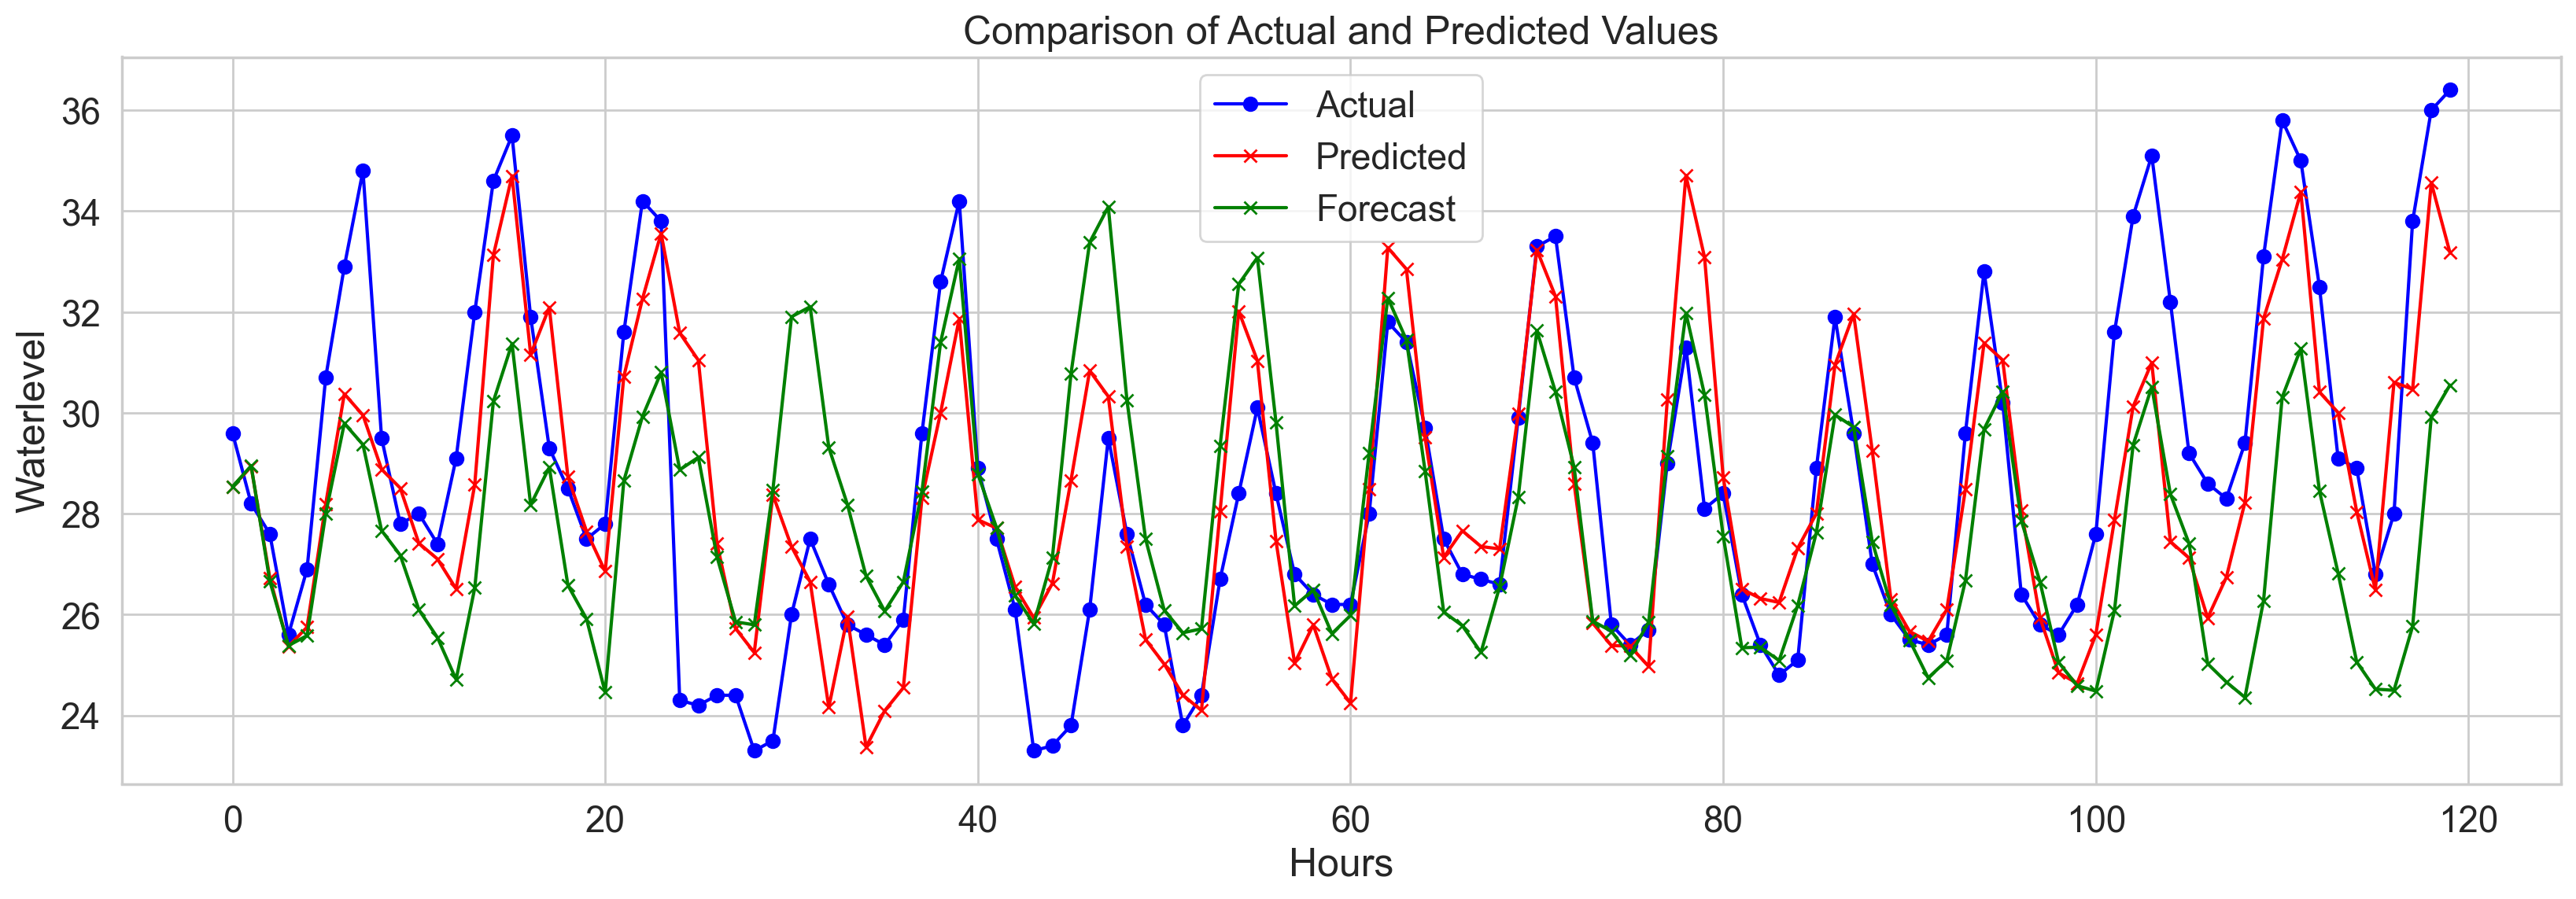

Time: 0, CNN_model, Batch_size = 64
     Size  SIM  MAE  RMSE  FSD    R   NSE   MSE
  3 hours 0.69 0.92  0.92 1.47 0.60 -0.22  0.86
  6 hours 0.83 1.16  1.39 1.60 0.78  0.31  1.94
 12 hours 0.85 1.81  2.27 1.63 0.83  0.19  5.14
 24 hours 0.81 2.55  2.99 1.71 0.83 -0.11  8.93
 36 hours 0.82 2.77  3.21 1.72 0.42  0.12 10.30
 72 hours 0.86 2.26  2.86 1.76 0.50  0.18  8.21
120 hours 0.86 2.32  3.00 1.76 0.51  0.16  8.97





C:\Users\ADMIN\AppData\Local\Temp\ipykernel_959456\902230330.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)


IndexError: index 2392 is out of bounds for axis 0 with size 1658

In [27]:
import random
times = [0] + [random.randint(1, 1500) for _ in range(9)]
for i in models:
    custom_objects = {'AttentionLayer': AttentionLayer}
    model = load_model(f'{i.__name__}64', custom_objects=custom_objects)
    model = load_model(f'{i.__name__}64.h5', custom_objects=custom_objects)

    for time in times:
        y_fc = forecast(model, 120, time)
        y_pred = model.predict(x_test[time:], verbose=0)

        y_test_original = scaler.inverse_transform(y_test)
        y_pred_original = scaler.inverse_transform(y_pred)
        y_fc_original = scaler.inverse_transform(y_fc)

        plt.figure(figsize=(20, 6))

        plt.plot(y_test_original[time : time + 120].flatten(), label='Actual', color='blue', marker='o')
        plt.plot(y_pred_original[: 120], label='Predicted', color='red', marker='x')
        plt.plot(y_fc_original[: 120].flatten(), label='Forecast', color='green', marker='x')
        plt.title('Comparison of Actual and Predicted Values')
        plt.xlabel('Hours')
        plt.ylabel('Waterlevel')
        plt.legend()

        plt.show()

        print (f"Time: {time}, {i.__name__}, Batch_size = {batch_size}" )

        time_forecast = [3,  6, 12, 24, 36, 72, 120]  
        metrics_df = pd.DataFrame(columns=["Size", "SIM", "MAE", "RMSE", "FSD", "R", "NSE", "MSE"])
        for hours in time_forecast:
            
            metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
        
            metrics['Size'] = f'{hours} hours'
            metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        metrics_df = metrics_df.round(2)    
        print(metrics_df.to_string(index=False))
        print("\n\n")

## Batch Size = 32

In [ ]:
batch_size = 32
# for i in models:
#     model = i()
#     model.fit(
#         x_train, y_train,
#         validation_data=(x_val, y_val),
#         epochs=200,
#         batch_size=batch_size,
#         callbacks=[EarlyStopping(monitor='val_loss', 
#                                 patience=10, 
#                                 restore_best_weights=True)],                       
#         verbose=1,
#         shuffle=False
#     ) 
#     model.save(f'{i.__name__}32')
#     model.save(f'{i.__name__}32.h5')

In [ ]:
import random

for i in models:
    custom_objects = {'AttentionLayer': AttentionLayer}
    model = load_model(f'{i.__name__}32', custom_objects=custom_objects)
    model = load_model(f'{i.__name__}32.h5', custom_objects=custom_objects)
    
    for time in times:
        y_fc = forecast(model, 120, time)
        y_pred = model.predict(x_test[time:], verbose=0)

        y_test_original = scaler.inverse_transform(y_test)
        y_pred_original = scaler.inverse_transform(y_pred)
        y_fc_original = scaler.inverse_transform(y_fc)

        plt.figure(figsize=(20, 6))

        plt.plot(y_test_original[time : time + 120].flatten(), label='Actual', color='blue', marker='o')
        plt.plot(y_pred_original[: 120], label='Predicted', color='red', marker='x')
        plt.plot(y_fc_original[: 120].flatten(), label='Forecast', color='green', marker='x')
        plt.title('Comparison of Actual and Predicted Values')
        plt.xlabel('Hours')
        plt.ylabel('Waterlevel')
        plt.legend()

        plt.show()

        print (f"Time: {time}, {i.__name__}, Batch_size = {batch_size}" )

        time_forecast = [3,  6, 12, 24, 36, 72, 120]  
        metrics_df = pd.DataFrame(columns=["Size", "SIM", "MAE", "RMSE", "FSD", "R", "NSE", "MSE"])
        for hours in time_forecast:
            
            metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
        
            metrics['Size'] = f'{hours} hours'
            metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        metrics_df = metrics_df.round(2)    
        print(metrics_df.to_string(index=False))
        print("\n\n")

## Batch Size = 128

In [ ]:
batch_size = 128
# for i in models:
#     model = i()
#     model.fit(
#         x_train, y_train,
#         validation_data=(x_val, y_val),
#         epochs=200,
#         batch_size=batch_size,
#         callbacks=[EarlyStopping(monitor='val_loss', 
#                                 patience=10, 
#                                 restore_best_weights=True)],                       
#         verbose=1,
#         shuffle=False
#     ) 
#     model.save(f'{i.__name__}128')
#     model.save(f'{i.__name__}128.h5')

In [ ]:
import random

for i in models:
    custom_objects = {'AttentionLayer': AttentionLayer}
    model = load_model(f'{i.__name__}128', custom_objects=custom_objects)
    model = load_model(f'{i.__name__}128.h5', custom_objects=custom_objects)
    
    for time in times:
        y_fc = forecast(model, 120, time)
        y_pred = model.predict(x_test[time:], verbose=0)

        y_test_original = scaler.inverse_transform(y_test)
        y_pred_original = scaler.inverse_transform(y_pred)
        y_fc_original = scaler.inverse_transform(y_fc)

        plt.figure(figsize=(20, 6))

        plt.plot(y_test_original[time : time + 120].flatten(), label='Actual', color='blue', marker='o')
        plt.plot(y_pred_original[: 120], label='Predicted', color='red', marker='x')
        plt.plot(y_fc_original[: 120].flatten(), label='Forecast', color='green', marker='x')
        plt.title('Comparison of Actual and Predicted Values')
        plt.xlabel('Hours')
        plt.ylabel('Waterlevel')
        plt.legend()

        plt.show()

        print (f"Time: {time}, {i.__name__}, Batch_size = {batch_size}" )

        time_forecast = [3,  6, 12, 24, 36, 72, 120]  
        metrics_df = pd.DataFrame(columns=["Size", "SIM", "MAE", "RMSE", "FSD", "R", "NSE", "MSE"])
        for hours in time_forecast:
            
            metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
        
            metrics['Size'] = f'{hours} hours'
            metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
        metrics_df = metrics_df.round(2)    
        print(metrics_df.to_string(index=False))
        print("\n\n")